In [132]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
from tqdm.auto import tqdm
import random
import os
import pickle
import math
import time

In [133]:
BASE_PATH = "D:/Aman/IIIT Delhi/IP-RL/GridWorldExperiments/Logs/"
TIMEOUT = 5000
EPISODES = 700
DECAY_FREQ = 500
MEMORY_VISUALIZE_FREQ = {100:100,1000:250,10000:1000} # Visualization frequency for different buffer sizes
grid_dim = 64
action_map = {0:"R",1:"D",2:"L",3:"U"}

In [134]:
class Environment:
    
    def __init__(self, gridsize):        
        # Constants
        self.gridsize = gridsize 
        self.start_state = (self.gridsize-2,self.gridsize-2)
        self.terminal_states = [(self.gridsize//2,self.gridsize//2)] # Terminal states
        self.terminal_rewards = 0
        self.actions = [[0,1],[1,0],[0,-1],[-1,0]]  # Right,Down,Left,Up
        self.non_term_reward = -1
        
        # Grid Setup
        self.grid = np.ones((gridsize,gridsize))
        self.make_grid()
        
        self.reset()
        
    def make_grid(self):
        for i in range(self.gridsize//4,3*(self.gridsize//4)):
            self.grid[i,self.gridsize//4] = 0
            self.grid[i,3*(self.gridsize//4)-1] = 0
            
        for i in range(self.gridsize//4,3*(self.gridsize//4)):
            self.grid[self.gridsize//4,i] = 0
            self.grid[3*(self.gridsize//4)-1,i] = 0
            
        for i in range(self.gridsize//4,int(1.5*(self.gridsize//4))):
            self.grid[i,self.gridsize//4] = 1
            
        for state in self.terminal_states:
            self.grid[state] = 2
                
    def __get_neighbours(self,state):
        neighbours = []
        for action in self.actions:
            next_state = (state[0]+action[0],state[1]+action[1])
            # Checking for out of grid state
            if next_state[0]<0 or next_state[1]<0 or next_state[0]>=self.gridsize or next_state[1]>=self.gridsize:
                continue
            # Check if next state is a wall
            if self.grid[next_state] == 0:
                continue
            neighbours.append(next_state)
        return neighbours
        
    def compute_optimal_q_values(self):
        self.optimal_q = np.ones((self.gridsize,self.gridsize,len(self.actions)))
        self.optimal_v = -1*np.ones((self.gridsize,self.gridsize))
        for term in self.terminal_states:
            queue = [term]
            self.optimal_v[term] = 0
            reward = None 
            
            while len(queue) > 0:
                cur = queue.pop(0)
                if cur in self.terminal_states:
                    reward = self.terminal_rewards
                else:
                    reward = -self.non_term_reward
                    
                for neigh in self.__get_neighbours(cur):
                    updated_v = self.optimal_v[cur] + reward
                    if self.optimal_v[neigh] < 0:
                        self.optimal_v[neigh] = updated_v
                        queue.append(neigh)
                    elif self.optimal_v[neigh] > updated_v:
                        self.optimal_v[neigh] = updated_v
                        
        self.optimal_v = -1*self.optimal_v
        
        for i in range(self.gridsize):
            for j in range(self.gridsize):
                for a in range(len(self.actions)):
                    if self.grid[(i,j)] != 0:
                        self.current_state = (i,j)
                        reward, next_state, _ = self.step(a)
                        self.optimal_q[i,j,a] = self.optimal_v[next_state] + reward
                        
        self.reset()
        return self.optimal_q
                        
            
    def get_steps(self):
        return self.env_steps
    
    def is_terminal(self,state):
        if state in self.terminal_states: 
            return True
        return False
        
    def reset(self):
        self.current_state = self.start_state
        self.env_steps = 0
        return self.current_state
         
    def render(self):
        
        # get map value at current location
        cur_map_value = self.grid[self.current_state]
        
        # Mark current location on map
        self.grid[self.current_state] = 3
        
        # make a color map of fixed colors
        cmap = mpl.colors.ListedColormap(['orange','cyan','purple','red'])
        bounds=[0,0.5,1.5,2.5,3]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        # tell imshow about color map so that only set colors are used
        img = plt.imshow(self.grid ,interpolation='nearest', cmap = cmap,norm=norm)
        # make a color bar
        plt.colorbar(img,cmap=cmap,norm=norm,boundaries=bounds,ticks=[-5,0,5])
        plt.show()
        
        # Resetting original map value at current location
        self.grid[self.current_state] = cur_map_value
        
    def step(self, action):
        
        # updating episode step count
        self.env_steps+=1
        
        # Checking for special states
        if self.is_terminal(self.current_state):
            return self.terminal_rewards,self.current_state,True
        
        # Calculating next state
        next_state = (self.current_state[0]+self.actions[action][0],self.current_state[1]+self.actions[action][1])
        
        # Checking for out of grid state
        if next_state[0]<0 or next_state[1]<0 or next_state[0]>=self.gridsize or next_state[1]>=self.gridsize:
            return self.non_term_reward,self.current_state,False
        
        # Check if next state is a wall
        if self.grid[next_state] == 0:
            return self.non_term_reward,self.current_state,False
        
        # Returning next state and reward
        self.current_state = next_state
        return self.non_term_reward,next_state,False
    
    def step_async(self, state, action):
        self.env_steps -= 1
        actual_cur_state, self.current_state = self.current_state, state
        reward, next_state, done = self.step(action)
        self.current_state = actual_cur_state
        return reward, next_state, done
    

In [135]:
env = Environment(grid_dim)

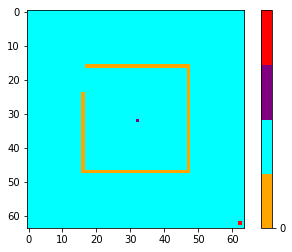

In [136]:
env.render()

In [137]:
class ReplayBuffer:
    
    def __init__(self, buffer_size=100, batch_sz=10):
        self.buffer_size = buffer_size
        self.batch_sz = batch_sz
        self.pointer = 0
        self.cur_size = 0
        self.buffer = [0 for i in range(buffer_size)]
        self.quorom = min(buffer_size/10,10000)
        self.hist = {"x":[],"y":[]}
        
    def at_quorom(self):
        return self.cur_size >= self.quorom
        
    def add(self,transition):
        state,_,_,_,_ = transition
        x,y = state
        if self.cur_size < self.buffer_size:
            self.hist["x"].append(x)
            self.hist["y"].append(y)
        else:
            self.hist["x"][self.pointer] = x
            self.hist["y"][self.pointer] = y
        self.buffer[self.pointer] = transition
        self.pointer = (self.pointer+1)%self.buffer_size
        self.cur_size = min(self.cur_size+1,self.buffer_size)
        
    def sample(self):
        idx = random.randint(0,self.cur_size-1)
        transition = self.buffer[idx]
        return idx, transition
    
    def sample_batch(self):
        batch = []
        indices = []
        while len(batch) < self.batch_sz:
            idx, transition = self.sample()
            if idx not in indices:
                indices.append(idx)
                batch.append(transition)
        return batch
    
    def get_buffer_histogram(self):
        return self.hist


In [232]:
class BucketedGeometricDecayReplayBuffer(ReplayBuffer):
        
        def __init__(self, buffer_size=100, batch_sz=10, p = 0.11, num_buckets=20):
            self.bucket_sz = buffer_size//num_buckets # Ensure that num_buckets is divisible by buffer_size
            self.num_buckets = num_buckets
            self.p = p
            ReplayBuffer.__init__(self, buffer_size=buffer_size, batch_sz=batch_sz)
            
        def sample(self):
            while True:
                sample_idx = random.randint(0,min(self.bucket_sz-1,self.cur_size-1))
                bucket_idx = -1
                bucket_lim = min(int(math.ceil(self.cur_size/self.bucket_sz)),self.num_buckets)

                while not(bucket_idx>=0 and bucket_idx<bucket_lim):
                    bucket_idx = int(np.random.geometric(self.p))-1

                idx = (self.pointer - 1 - self.bucket_sz*(bucket_idx) - sample_idx)%self.buffer_size     

                if idx >= self.cur_size:
                    continue

                transition = self.buffer[idx]
                return idx, transition    

In [233]:
class Logger:
    
    def __init__(self,path,name):
        self.path = BASE_PATH + path
        self.name = name
        self.font = cv2.FONT_HERSHEY_PLAIN
        self.visualize_mem_steps = 0
        self.snapshot_fig, self.snapshot_ax = plt.subplots()
        self.logs={}
        self.create()
        self.setup()
        
    def create(self):
        os.makedirs(self.path,exist_ok=True)
        os.makedirs(self.path+self.name.split(".")[0]+"-memory/",exist_ok=True)
        open(self.path+self.name, 'ab').close()
        
    def make_plot(self):
        fig1, ax1 = plt.subplots()
        ax1.set_title("Train Log - Epsiode Returns")
        ax1.plot(self.logs["returns"])
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Returns")
        fig1.savefig(self.path+self.name+'-returns.png',dpi=800)
        ax1.clear()
        
#         fig2, ax2 = plt.subplots()
        ax1.set_title("Train Log - Epsiode Variance")
        ax1.plot(self.logs["variance"])
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Variance")
        fig1.savefig(self.path+self.name+'-variance.png',dpi=800)
        ax1.clear()
        
#         fig3, ax3 = plt.subplots()
        ax1.set_title("Train Log - Epsiode Entropy")
        ax1.plot(self.logs["entropy"])
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Entropy")
        fig1.savefig(self.path+self.name+'-entropy.png',dpi=800)
        ax1.clear()
        
#         fig4, ax4 = plt.subplots()
        ax1.set_title("Train Log - Epsiode Running Variance")
        ax1.plot(self.logs["running_variance"])
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Running Variance")
        fig1.savefig(self.path+self.name+'-runningvariance.png',dpi=800)
        fig1.clf()
        plt.close(fig1)
                
    def setup(self):
        self.logs["returns"] = []
        self.logs["variance"] = []
        self.logs["running_variance"] = []
        self.logs["entropy"] = []
        
    def step(self,ep_stats):
        self.logs["returns"].append(ep_stats["return"])
        self.logs["variance"].append(ep_stats["variance"])
        self.logs["running_variance"].append(ep_stats["running_variance"])
        self.logs["entropy"].append(ep_stats["entropy"])
        
    def save(self):
        if len(self.logs["returns"])%EPISODES==0 and len(self.logs["returns"])>0:
            self.make_plot()
        with open(self.path+self.name,"wb") as f:
            pickle.dump(self.logs,f)
            
    def save_replay_snapshot(self,histogram,episode):
        self.snapshot_ax.hist2d(histogram["x"], histogram["y"], bins =[grid_dim, grid_dim], range=[[0, grid_dim-1], [0,grid_dim-1]])
        
        self.snapshot_fig.gca().invert_yaxis()
        self.snapshot_fig.canvas.draw()

        data = np.frombuffer(self.snapshot_fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(self.snapshot_fig.canvas.get_width_height()[::-1] + (3,))
        cv2.putText(data, "Episode="+str(episode), (5,15), self.font, 1, (0, 255, 0), 1,)
        
        im_name = str(self.visualize_mem_steps)
        im_name = (6-len(im_name))*"0" + im_name + "_" + str(episode)
        save_path = self.path+self.name.split(".")[0]+"-memory/"+im_name+'.jpg'
        cv2.imwrite(save_path,data)
        
        self.visualize_mem_steps += 1
        self.snapshot_ax.clear()
            
    def load(self):
        self.logs = pickle.load(f)

In [234]:
class Agent:
    
    def __init__(self,state_space=(128,128),action_space=4,epsilon=0.1,decay_factor=0.7,decay_freq=100,base_epsilon=0.8,min_epsilon=0.1):
        self.policy = np.zeros((*state_space,action_space))
        self.action_space = action_space
        self.epsilon = epsilon
        self.decay_factor = decay_factor
        self.decay_freq = decay_freq
        self.min_epsilon = min_epsilon
        self.base_epsilon = base_epsilon
        
    def update_epsilon(self,step):
        self.epsilon = max(self.base_epsilon*self.decay_factor**(step//self.decay_freq),self.min_epsilon)
        
    def greedy_action(self,state):
        x,y = state
        return np.argmax(self.policy[x,y,:])
    
    def epsilon_greedy_action(self,state):
        x,y = state
        greedy = np.random.uniform() > self.epsilon
        if greedy:
            return np.argmax(self.policy[x,y,:])
        return np.random.randint(4)

In [235]:
class QTracker:
    
    def __init__(self,q_opt,state_space=(128,128),action_space=4,max_history=50):
        self.max_history = max_history
        self.q_history = np.zeros((*state_space,action_space,max_history))
        self.q_pointer = np.ones((*state_space,action_space,2))
        self.q_opt = q_opt
        
    def step(self, q_value, state, action):
        ptr_idx = (state[0],state[1],action,0)
        history_idx = (state[0],state[1],action,int(self.q_pointer[ptr_idx]%self.max_history))

        self.q_history[history_idx]=q_value
        self.q_pointer[ptr_idx] = (self.q_pointer[ptr_idx]+1)%self.max_history
        if self.q_pointer[ptr_idx] == 0:
            self.q_pointer[state[0],state[1],action,1] = 0 # implies that max_history samples have been populated
        
    def get_running_mean(self,state,action):
        samples = []
        if self.q_pointer[(*state,action,1)] == 1:
            samples = self.q_history[state[0],state[1],action,0:int(self.q_pointer[state[0],state[1],action,0])]
        else:
            samples = self.q_history[state[0],state[1],action,:]
        expected_target = np.sum(samples)
        return expected_target
    
    def get_optimal_mean(self,state,action):
        return self.q_opt[state[0],state[1],action]


In [236]:
class Runner:

    def __init__(self, config):
        self.gamma = config["gamma"]
        self.n = config["n"]
        self.batch_sz = config["batch_sz"]
        self.alpha = config["alpha"]
        self.epsilon = config["epsilon"]
        self.convergence_threshold = config["convergence_threshold"]
        self.buffer_sz = config["buffer_sz"]
        self.gridsize = config["gridsize"]
        self.max_history = config["max_history"]
        self.visualize_memory = config["visualize_memory"]
        self.experiment = config["experiment"]
        self.action_space = config['action_space']
        self.noise_prob = config["noise_prob"]
        self.config = config
        self.ep_stats = {}
        self.n_step_history = [0 for i in range(self.n+1)]
        self.n_step_ptr = 0
        self.s1,self.s2,self.s3=0,0,0
        
    def setup(self):
        self.agent = Agent(state_space=(self.gridsize,self.gridsize),action_space=self.config['action_space'], epsilon=self.epsilon)
        if self.config["experiment"] == "Geometric-Decay":
            self.memory = BucketedGeometricDecayReplayBuffer(buffer_size=self.buffer_sz,batch_sz=self.batch_sz,p=self.config["geometric_p"],num_buckets=self.config["geometric_buckets"])
        else:
            self.memory = ReplayBuffer(buffer_size=self.buffer_sz,batch_sz=self.batch_sz)
        self.env = Environment(gridsize=self.gridsize)
        self.logger = Logger(self.experiment+"/"+self.method+"/"+str(self.n)+"/",str(self.buffer_sz)+".pickle")
        self.q_tracker = QTracker(self.env.compute_optimal_q_values(),state_space=(self.gridsize,self.gridsize),action_space=self.config['action_space'],max_history=self.config["max_history"])  
        
    def decay_alpha(self,eps):
        self.alpha = max(self.alpha*(0.7**(eps//DECAY_FREQ)),0.0001)
        
    def decay_noise(self,eps):
        self.noise_prob =  self.config["noise_prob"]*(self.config["noise_decay"]**(eps//self.config["noise_decay_freq"]))
        
    def reset_episode_log(self):
        self.ep_stats["return"] = 0
        self.ep_stats["variance"] = 0
        self.ep_stats["running_variance"] = 0
        self.ep_stats["entropy"] = 0
        self.ep_stats["train_step"] = 0
        
    def update_episode_log(self,reward,variance,running_variance,entropy):
        self.ep_stats["train_step"] += 1
        self.ep_stats["return"] += reward
        self.ep_stats["variance"] += variance
        self.ep_stats["running_variance"] += running_variance
        self.ep_stats["entropy"] += entropy
        
    def process_episode_log(self):
        self.ep_stats["running_variance"] = self.ep_stats["running_variance"]/self.ep_stats["train_step"]
        self.ep_stats["variance"] = self.ep_stats["variance"]/self.ep_stats["train_step"]
        self.ep_stats["entropy"] = self.ep_stats["entropy"]/self.ep_stats["train_step"]     
        
    def reset_n_step_buffer(self):
        self.n_step_history = [0 for i in range(self.n+1)]
        self.n_step_ptr = 0
        
    def update_n_step_buffer(self,action,next_state,reward):
        self.n_step_history[self.n_step_ptr] = (next_state,action,reward)
        self.n_step_ptr = (self.n_step_ptr+1)%(self.n+1)
        
    def save_q_values(self):
        with open(BASE_PATH+self.experiment+"/"+self.method+"/"+str(self.n)+"/"+str(self.buffer_sz)+"-q.pickle","wb") as f:
            pickle.dump(self.agent.policy,f)
            
    def get_action_probability(self,state,action):
        if action == np.argmax(self.agent.policy[state[0],state[1],:]):
            return 1 - self.agent.epsilon + self.agent.epsilon/self.agent.action_space
        return self.agent.epsilon/self.agent.action_space
    
    def get_entropy(self,q_vec):
        entropy = 0
        abs_max = float('-inf')
        for i in range(q_vec.shape[0]):
            if abs(q_vec[i]) > abs_max:
                abs_max = abs(q_vec[i])
                
        for i in range(q_vec.shape[0]):
            norm = q_vec[i] / (abs_max+10**-5)
            entropy += -norm*math.exp(norm)
        
        return entropy
    
    def get_variance(self,state,action,target,q_val):
        self.q_tracker.step(q_val,state,action)
        running_expectation = self.q_tracker.get_running_mean(state,action)
        expectation = self.q_tracker.get_optimal_mean(state,action)
        variance = (target-expectation)**2
        running_variance = (target-running_expectation)**2
        return variance, running_variance
            
    def learn(self):
        for eps in tqdm(range(EPISODES)):
            cur_state = self.env.reset()
            self.reset_episode_log()
            done = False
            self.reset_n_step_buffer()
            self.update_n_step_buffer(0,cur_state,-1)
            self.decay_alpha(eps)
            while not done and self.env.get_steps()<TIMEOUT:
                action = self.agent.epsilon_greedy_action(cur_state)
                if not self.memory.at_quorom():
                    action = random.randint(0,3)
                reward, next_state, done = self.env.step(action)
                self.update_n_step_buffer(action,next_state,reward)
                transition = (*self.make_transition(),done)
                self.memory.addx(transition)
                if not self.memory.at_quorom():
                    continue
                batch = self.memory.sample_batch()
                variance,running_variance,entropy = self.train_on_batch(batch)    
                cur_state = next_state
                self.update_episode_log(reward,variance,running_variance,entropy)
    
            self.process_episode_log()
            self.logger.step(self.ep_stats)
            self.logger.save()
        self.save_q_values()
            

In [248]:
class nStepRunner(Runner):
    
    def __init__(self, config):
        self.method = "TD"
        Runner.__init__(self,config)
        
    def uncorrected_n_step(self,start_ptr):
        reward = 0
        cur_gamma = 1
        for ptr in range(start_ptr+1,start_ptr+1+self.n):
            _,state,r = self.n_step_history[ptr%(self.n+1)]
            if state is None: # Truncate reward as goal reached
                break
            reward += r*cur_gamma
            cur_gamma = cur_gamma*self.gamma
        return reward
           
    def make_transition(self):
        start_ptr = (self.n_step_ptr)%(self.n+1)
        start_state,_,_ = self.n_step_history[start_ptr]
        _,action,_ = self.n_step_history[(start_ptr+1)%(self.n+1)]
        reward = self.uncorrected_n_step(start_ptr)
        final_state,_,_ = self.n_step_history[(start_ptr-1)%(self.n+1)]
        transition = (start_state,action,reward,final_state)
        return transition
        
    def get_TD_n_target(self,reward,q_next):
        target = reward + (self.gamma**self.n)*q_next
        return target     
    
    def refresh_transition(self,state):
        cur_state = state
        cur_action, next_state, done = None, None, False
        reward, cur_gamma = 0, 1
        for step in range(self.n):
            action = self.agent.epsilon_greedy_action(cur_state)
            if step == 0:
                cur_action = action
            r, next_state, done = self.env.step_async(cur_state,action)
            if "Noisy" in self.experiment:
                if random.random() < self.noise_prob:
                    r, next_state, done = self.env.step_async(cur_state,random.randint(0,self.config["action_space"]-1))
            reward += r*cur_gamma
            cur_gamma = cur_gamma*self.gamma
            cur_state = next_state
        return cur_action, reward, next_state, done
    
    def train_on_batch(self,batch):
        variance,running_variance,entropy = 0,0,0
        for transition in batch:
            cur_state,action,reward,next_state,done = transition
            if "Refresh" in self.experiment:
                action,reward,next_state,done = self.refresh_transition(cur_state)
            q_cur = self.agent.policy[cur_state[0],cur_state[1],action]
            q_next = 0
            if next_state is not None: # Episode in progress, No truncation needed
                next_action = self.agent.greedy_action(next_state)
                q_next = self.agent.policy[next_state[0],next_state[1],next_action]
            target = self.get_TD_n_target(reward,q_next)
            self.agent.policy[cur_state[0],cur_state[1],action] = q_cur + self.alpha*(target - q_cur)
            # Updating stats
            if next_state is not None:
                entropy += self.get_entropy(self.agent.policy[next_state[0],next_state[1],:])
            v, r_v = self.get_variance(cur_state,action,target,self.agent.policy[cur_state[0],cur_state[1],action])
            variance += v
            running_variance += r_v
            
        return variance/len(batch),running_variance//len(batch),entropy/len(batch)
        
    def learn_n_step(self):
                
        total_steps = 0
            
        for eps in tqdm(range(EPISODES)):
            cur_state = self.env.reset()
            self.reset_episode_log()
            self.decay_alpha(eps)
            self.decay_noise(eps)
            self.reset_n_step_buffer()
            self.update_n_step_buffer(0,cur_state,-1)
            T = TIMEOUT
            done = False
            reward = 0
            
            while True:
                                
                time_step = self.env.get_steps()
                
                if time_step == TIMEOUT:
                    break
                    
                # Not timeout or termination
                if time_step < T:
                    action = self.agent.epsilon_greedy_action(cur_state)
                    if not self.memory.at_quorom():
                        action = random.randint(0,3)
                    reward, next_state, done = self.env.step(action)
                    cur_state = next_state
                    self.update_n_step_buffer(action,next_state,reward)
                    # reached terminal state
                    if done:
                        T = time_step
                    # incrementing total env steps
                    total_steps += 1
                
                # Not timeout
                elif time_step != TIMEOUT:
                    time_step += 1    
                    self.update_n_step_buffer(-1,None,0)
                    
                if self.visualize_memory and total_steps%MEMORY_VISUALIZE_FREQ[self.buffer_sz]==0:
                    memory_histogram = self.memory.get_buffer_histogram()
                    self.logger.save_replay_snapshot(memory_histogram,eps+1)
                        
                tau = time_step - (self.n - 1)
                
                if tau >= 0:
                    transition = (*self.make_transition(),done)
                    self.memory.add(transition)
                    
                    if not self.memory.at_quorom():
                        continue
                    
                    batch = self.memory.sample_batch()
                    if 'CER' in self.config["experiment"]:
                        batch[-1] = transition
                    variance,running_variance,entropy = self.train_on_batch(batch)
                    self.update_episode_log(reward,variance,running_variance,entropy)
                    
                if tau >= T:
                    break
                                             

            if not self.memory.at_quorom():
                continue
                    
            self.process_episode_log()
            self.logger.step(self.ep_stats)
            self.logger.save()
        self.save_q_values()

# Tree Backup - State Trajectory and Replay Transition Scheme

### Given reward steps - _n_ and  current state - _S0_
Current Action = A0 <br>
State Trajectory = { (S1,A1), (S2,A2), ... , (Sn) } <br>
Rewards = { R1, R2, .... Rn }

In [249]:
class treeRunner(Runner):
    
    def __init__(self,config):
        self.method = "tree"
        Runner.__init__(self,config)
        
    def refresh_transition(self,cur_state):
        state = cur_state
        action = self.agent.epsilon_greedy_action(state)
        rewards = []
        state_trajectory = []
        
        for step in range(self.n): 
            reward, next_state, done = self.env.step_async(state,action)
            if "Noisy" in self.experiment:
                if random.random() < self.noise_prob:
                    reward, next_state, done = self.env.step_async(state,random.randint(0,self.config["action_space"]-1))
            next_action = self.agent.epsilon_greedy_action(next_state)
            rewards.append(reward)
            state_trajectory.append([next_state,next_action])
            
        state_trajectory[-1] = [state_trajectory[-1][0]]
        return action,rewards,state_trajectory,done
        
    def make_transition(self):
        start_ptr = (self.n_step_ptr)%(self.n+1)
        start_state,_,_ = self.n_step_history[start_ptr]
        _,action,_ = self.n_step_history[(start_ptr+1)%(self.n+1)]
        rewards = []
        state_trajectory = []
        for ptr in range(start_ptr+1,start_ptr+1+self.n):
            state,prev_action,r = self.n_step_history[ptr%(self.n+1)]
            if state is None: # Truncate reward as goal reached
                break
            if len(state_trajectory) > 0:
                state_trajectory[-1].append(prev_action)
            rewards.append(r)
            state_trajectory.append([state])           
        transition = (start_state,action,rewards,state_trajectory)
        return transition
    
    # Σa π(a|s)Q(s,a)
    def get_state_expectation(self,state): 
        expectation = 0
        for action in range(4):
            expectation += self.get_action_probability(state,action)*self.agent.policy[state[0],state[1],action]
        return expectation
        
    def get_tree_target(self,rewards,state_trajectory):
        target = 0
        cur_gamma = 1
        policy_prob = 1
        for lvl in range(len(state_trajectory)):
            target += cur_gamma*policy_prob*rewards[lvl]
            cur_gamma *= self.gamma   
            next_state = state_trajectory[lvl][0]
            if next_state is None: # truncate target since goal has been reached
                break 
            elif len(state_trajectory[lvl]) == 1: # final state
                target += cur_gamma*policy_prob*self.get_state_expectation(next_state)
            else: # intermediate states
                next_action = state_trajectory[lvl][1]
                target += cur_gamma*policy_prob*self.get_state_expectation(next_state)
                policy_prob *= self.get_action_probability(next_state,next_action)
                target -= cur_gamma*policy_prob*self.agent.policy[next_state[0],next_state[1],next_action]

        return target     
    
    def train_on_batch(self,batch):
        variance,running_variance,entropy,ctr = 0,0,0,0
        for transition in batch:
            cur_state,action,rewards,state_trajectory,done = transition
            if "Refresh" in self.experiment:
                action,rewards,state_trajectory,done = self.refresh_transition(cur_state)
            q_cur = self.agent.policy[cur_state[0],cur_state[1],action]
            final_state = state_trajectory[-1][0]
            target = self.get_tree_target(rewards,state_trajectory)
            self.agent.policy[cur_state[0],cur_state[1],action] = q_cur + self.alpha*(target - q_cur)
            # Updating stats
            if final_state is not None:
                entropy += self.get_entropy(self.agent.policy[final_state[0],final_state[1],:])
            v, r_v = self.get_variance(cur_state,action,target,self.agent.policy[cur_state[0],cur_state[1],action])
            variance += v
            running_variance += r_v
            ctr += 1
            
        return variance/ctr,running_variance/ctr,entropy/ctr
        
    def learn_n_step(self):
        
        total_steps = 0
                
        for eps in tqdm(range(EPISODES)):
            cur_state = self.env.reset()
            self.reset_episode_log()
            self.decay_alpha(eps)
            self.decay_noise(eps)
            self.reset_n_step_buffer()
            self.update_n_step_buffer(0,cur_state,-1)
            
            T = TIMEOUT
            done = False
            reward = 0
            
            while True:
                                
                time_step = self.env.get_steps()
                
                if time_step == TIMEOUT:
                    break
                    
                # Not timeout or termination
                if time_step < T:
                    action = self.agent.epsilon_greedy_action(cur_state)
                    if not self.memory.at_quorom():
                        action = random.randint(0,3)
                    reward, next_state, done = self.env.step(action)
                    cur_state = next_state
                    self.update_n_step_buffer(action,next_state,reward)
                    # reached terminal state
                    if done:
                        T = time_step
                    # incrementing total env steps
                    total_steps += 1
                
                # Not timeout
                elif time_step != TIMEOUT:
                    time_step += 1    
                    self.update_n_step_buffer(-1,None,0)
                    
                if self.visualize_memory and total_steps%MEMORY_VISUALIZE_FREQ[self.buffer_sz]==0:
                    memory_histogram = self.memory.get_buffer_histogram()
                    self.logger.save_replay_snapshot(memory_histogram,eps+1)
                        
                tau = time_step - (self.n - 1)
                
                if tau >= 0:
                    transition = (*self.make_transition(),done)
                    self.memory.add(transition)
                    
                    if not self.memory.at_quorom():
                        continue
                    
                    batch = self.memory.sample_batch()
                    
                    if 'CER' in self.config["experiment"]:
                        batch[-1] = transition
                        
                    variance,running_variance,entropy = self.train_on_batch(batch)
                    self.update_episode_log(reward,variance,running_variance,entropy)
                    
                if tau >= T:
                    break
                                             

            if not self.memory.at_quorom():
                continue
                    
            self.process_episode_log()
            self.logger.step(self.ep_stats)
            self.logger.save()
        self.save_q_values()

In [256]:
config = {
    "experiment":"CER-Refresh", # "Uniform / Refresh / Refresh-Noisy / Geometric-Decay / Small-Big / CER / CER-Refresh / PER
    "buffer_sz":10000, # 100 / 1000 / 10000
    "n":1, # 1 / 2 / 3
    
    "gridsize":grid_dim, # default = 64
    "action_space":4, # default = 4
    "batch_sz":10, # default = 10
    "alpha":0.1, # default = 0.1
    "epsilon":0.1, # default = 0.1
    "gamma":0.99, # default = 0.99
    "max_history":10, # default = 10
    "convergence_threshold":10**-4, # default = 10**-4
    
    "visualize_memory":False,
    
    # Noisy Refresh Parameters
    "noise_prob":0.5, # noise injection prob in noisy refresh regime
    "noise_decay":0.5, # noise injection prob decay in noisy refresh regime
    "noise_decay_freq":150,  # noise injection prob reduction frequency in noisy refresh regime
    
    # Geometric Decay Buffer Parameters
    "geometric_p":0.11, # success probability of geometric distribution for Geometric Decay buffer
    "geometric_buckets":10, # active buckets in geometric distribution for Geometric Decay buffer
    
    # Moving Geometric Decay Buffer Parameters
    
}

HBox(children=(FloatProgress(value=0.0, max=700.0), HTML(value='')))

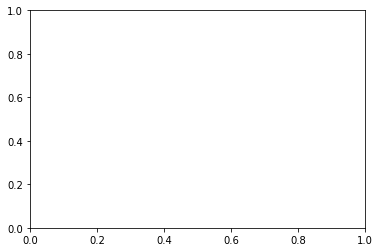

In [257]:
runner = nStepRunner(config)
# runner = treeRunner(config)
runner.setup()
runner.learn_n_step()

In [40]:
for exp in ["CER-Refresh","CER"]:
    for buff_sz in [100,10000]:
        for n in [1,3]:
            config['n'] = n 
            config['buffer_sz'] = buff_sz
            config['experiment'] = exp
            runner = treeRunner(config)
            runner.setup()
            runner.learn_n_step()

# for buff_sz in [100,1000,10000]:
#     for n in [1,2,3]:
#         config['n'] = n 
#         config['buffer_sz'] = buff_sz
#         runner = treeRunner(config)
#         runner.setup()
#         runner.lear n_n_step()

HBox(children=(FloatProgress(value=0.0, max=700.0), HTML(value='')))

HBox(children=(FloatProgress(value=0.0, max=700.0), HTML(value='')))

HBox(children=(FloatProgress(value=0.0, max=700.0), HTML(value='')))

HBox(children=(FloatProgress(value=0.0, max=700.0), HTML(value='')))

HBox(children=(FloatProgress(value=0.0, max=700.0), HTML(value='')))

HBox(children=(FloatProgress(value=0.0, max=700.0), HTML(value='')))

HBox(children=(FloatProgress(value=0.0, max=700.0), HTML(value='')))

C:\Users\Aman M\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(FloatProgress(value=0.0, max=700.0), HTML(value='')))

In [14]:
print(runner.logger.logs["returns"][-20:])

[-123, -132, -121, -117, -138, -138, -125, -124, -126, -124, -146, -128, -123, -119, -128, -122, -127, -122, -121, -128]


In [106]:
print(runner.logger.logs["returns"][-20:])

[-4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997, -4997]


In [107]:
# for a in range(4):
#     for i in range(grid_dim):
#         for j in range(grid_dim):
#             print("% 1.1f"%(runner.agent.policy[i,j,a]),end=" ")
#         print()
#     print()


In [241]:
from glob import glob
import cv2
from tqdm import tqdm
path = "D:/Aman M/Videos/Burglary/vid6/"
outpath = "D:/Aman M/Videos/Burglary/vid6_enhanced/"
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))

In [242]:
os.makedirs(outpath,exist_ok=True)

In [243]:
frames = glob(path+"*")

In [244]:
for img in tqdm(frames):
    img_name = img.split("\\")[-1].split(".")[0]
    frame = cv2.imread(img)#cv2.cvtColor(,cv2.COLOR_BGR2GRAY)
    grey_scale = frame[:,:,0]
    enhanced = clahe.apply(grey_scale)
    enhanced_frame = np.zeros((grey_scale.shape[0],grey_scale.shape[1],3))
    enhanced_frame[:,:,0] = enhanced
    enhanced_frame[:,:,1] = enhanced
    enhanced_frame[:,:,2] = enhanced
    cv2.imwrite(outpath+img_name+".jpg",enhanced_frame)
    

100%|██████████████████████████████████████████████████████████████████████████████| 1965/1965 [04:20<00:00,  7.56it/s]
